# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Для начала импортируем нужные библиотеки:

In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None
from sklearn import svm

Поместим датасеты в переменные:

In [4]:
df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')

### Кратко ознакомимся с датасетами:

#### Первый датасет

In [5]:
df0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [6]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
df0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [8]:
df0.sample()

,id,f0,f1,f2,product
74105,5wL1T,1.795652,-0.289982,-0.431721,40.812025


#### Второй датасет

In [9]:
df1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [11]:
df1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


#### Третий датасет

In [12]:
df2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [14]:
df2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


**Вывод по блоку:**
- Данные не имеют пропуском
- Типы данных приведены к нужным типам
- Имеется ненужный столбец id, который будет мешать обучению, предлагаю его удалить
- Второй датасет имеет более широкую дисперсию по параметрам fo и f1, чем первый и третий датасеты, а также параметр f3 у второго датасета имеет меньшую дисперсию, чем параметры у первого и третьего датасета, возможно, стоит проверить признаки на мультиколлинеарность

### Проверка на мультиколлинеарность

In [15]:
df0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


- f1 и f0 имеет среднюю отрицательную корреляцию
- f2 и целевой признак имеют среднюю положительную корреляцию

In [16]:
df1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


- f2 и product имеют сильную корреляцию

In [17]:
df2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


- f2 и целевой признак имеют среднюю положительную корреляцию

###  Удаление столбцов

In [18]:
df0 = df0.drop(['id'], axis=1)
df1 = df1.drop(['id'], axis=1)
df2 = df2.drop(['id'], axis=1)

### Выбросы в данных

Проверим распределение данных:

In [19]:
def showkde(df):
    for column in df.columns:
        df[column].plot(kind='kde')
        plt.title('График плотностей {}'.format(column))
        plt.ylabel('Плотность')
        plt.show()

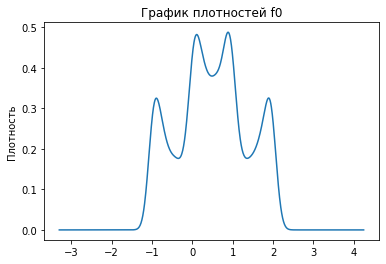

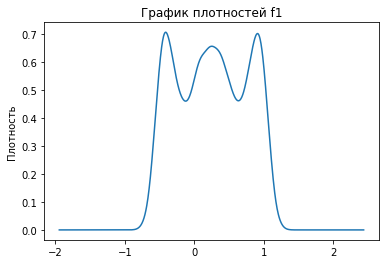

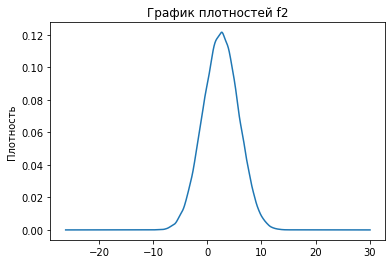

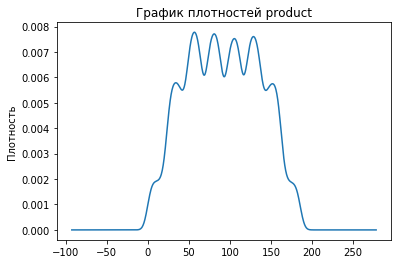

In [20]:
showkde(df0)

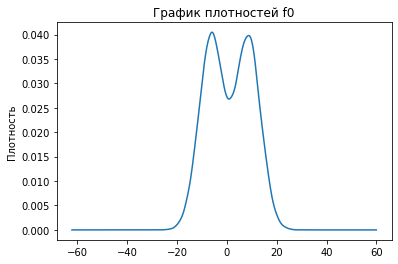

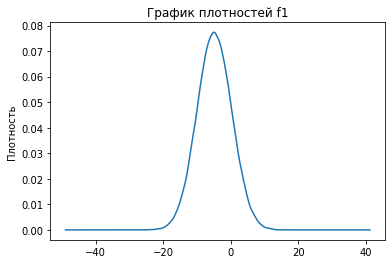

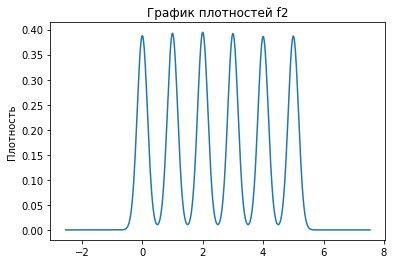

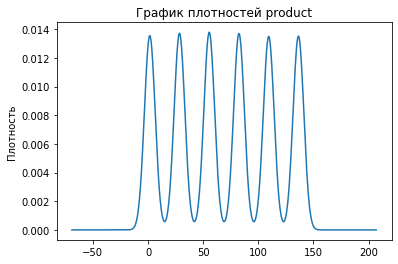

In [21]:
showkde(df1)

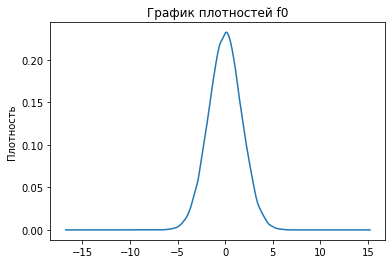

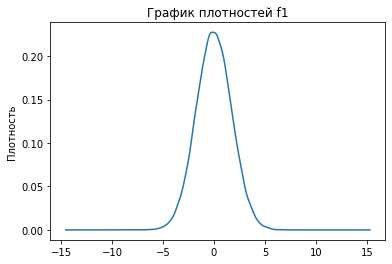

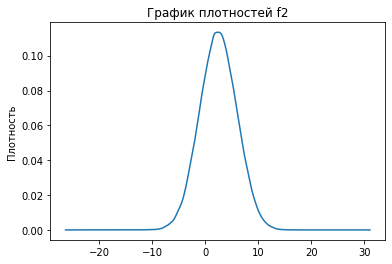

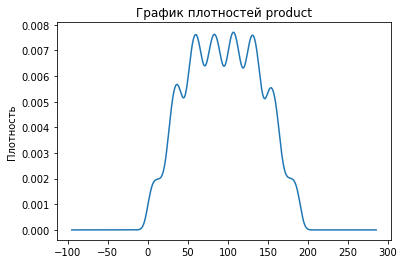

In [22]:
showkde(df2)

Здесь мы столкнулись с полимодальным распределением, означающим что выборка не является однородной, и наблюдения порождены двумя или более наложенными распределениями. Из этого следует, что вероятнее всего данные собирались в разных частях региона.

Проверим, есть ли в данных выбросы, которые негативно могут повляить на обучение модели:

In [23]:
def showboxplot(df):
    for column in range(len(df.columns)):
        df.boxplot(column=[df.columns[column]], figsize=(5,5))
        plt.show()   

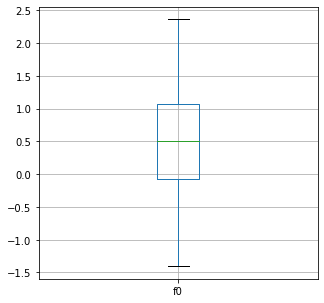

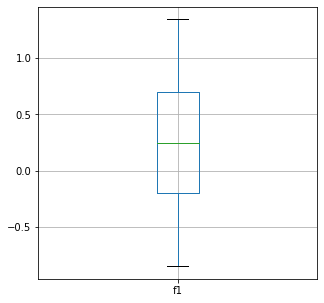

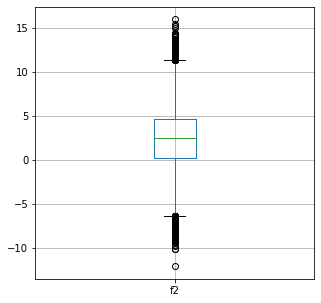

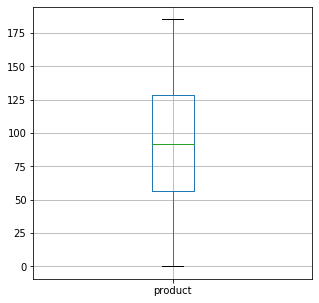

In [24]:
showboxplot(df0)

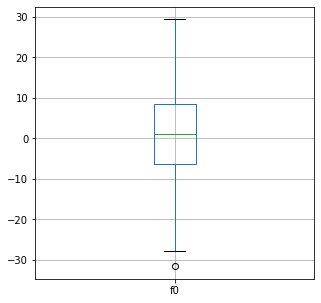

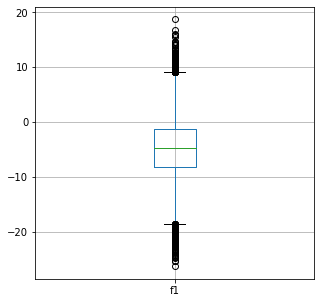

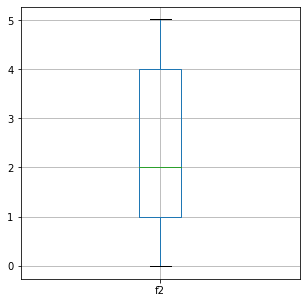

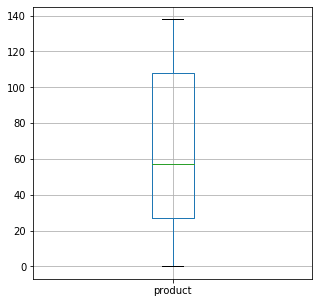

In [25]:
showboxplot(df1)

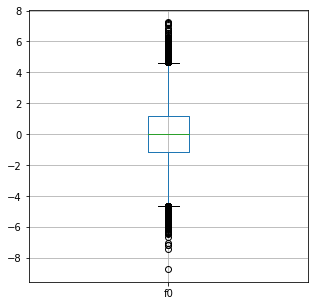

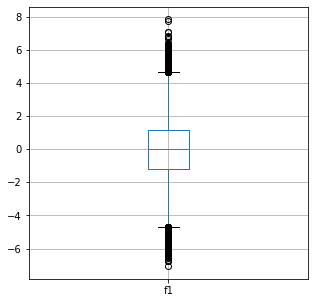

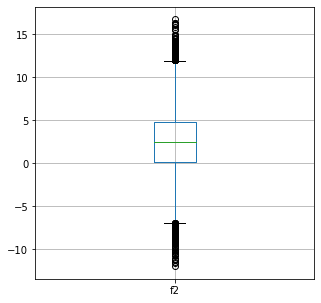

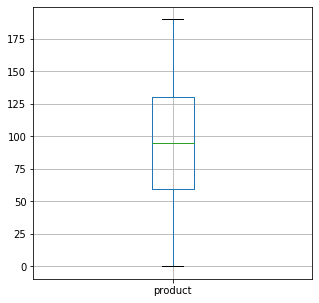

In [26]:
showboxplot(df2)

- В данных присутствуют выбросы, которые могут негативно повлиять на модель обучения, лучше от них избавиться

### Предобработка данных

#### Удаление выбросов из столбцов

По итогу у нас остались выбросы в столбцах:
- df0 - f2
- df1 - f1
- df2 - f0, f1, f2

От самымх ананомальных из них следует избавиться:

In [27]:
def delouts(df, column):
    quant_25 = int(df[column].quantile(0.15))
    quant_75 = int(df[column].quantile(0.90))
    first_part=quant_25-1.5*(quant_75-quant_25)
    second_part=quant_75+1.5*(quant_75-quant_25)
    print('Осталось строк:', len(df[(df[column] >= first_part) & (df[column] <= second_part)]))
    df_after_cleaning = df[(df[column] >= first_part) & (df[column] <= second_part)]
    return df_after_cleaning.reset_index(drop=True) 

In [28]:
df0 = delouts(df0, 'f2')
df1 = delouts(df1, 'f1')
df2 = delouts(df2, 'f0')
df2 = delouts(df2, 'f1')
df2 = delouts(df2, 'f2')

Осталось строк: 99983
Осталось строк: 99999
Осталось строк: 99914
Осталось строк: 99840
Осталось строк: 99837


**Выводы:**
- При проверке данных столкнулись полимодальным распределением, означающим что выборка не является однородной, и наблюдения порождены двумя или более наложенными распределениями. Из этого следует, что вероятнее всего данные собирались в разных частях региона.
- В данных присутствуют выбросы, которые могут негативно повлиять на модель обучения, лучше от них избавиться

## Обучение и проверка модели

### Подготовка признаков

Выделим целевой признак и обучающие, а также удалим признак f2 из первого датафрейма:

In [29]:
df0_target = df0['product']
df0_features = df0.drop(['product'], axis=1)

df1_target = df1['product']
df1_features = df1.drop(['product'], axis=1)

df2_target = df2['product']
df2_features = df2.drop(['product'], axis=1)

Для начала стоит разделить данные на обучающую и валидационную выборку:

In [30]:
df0_features_train, df0_features_valid, df0_target_train, df0_target_valid = train_test_split(df0_features, df0_target, test_size=0.25, random_state=12345)

In [31]:
df0_features_train.shape

(74987, 3)

In [32]:
df0_features_valid.shape

(24996, 3)

In [33]:
df0_target_train.shape

(74987,)

In [34]:
df0_target_valid.shape

(24996,)

In [35]:
df1_features_train, df1_features_valid, df1_target_train, df1_target_valid = train_test_split(df1_features, df1_target, test_size=0.25, random_state=12345) 

In [36]:
df1_features_train.shape

(74999, 3)

In [37]:
df1_features_valid.shape

(25000, 3)

In [38]:
df2_features_train, df2_features_valid, df2_target_train, df2_target_valid = train_test_split(df2_features, df2_target, test_size=0.25, random_state=12345)

In [39]:
df2_features_train.shape

(74877, 3)

In [40]:
df2_features_valid.shape

(24960, 3)

- Масштабируем признаки:

In [41]:
df0_scaler = StandardScaler()
df0_scaler.fit(df0_features_train)
df0_features_train = df0_scaler.transform(df0_features_train)
df0_features_valid = df0_scaler.transform(df0_features_valid)

In [42]:
df1_scaler = StandardScaler()
df1_scaler.fit(df1_features_train)
df1_features_train = df1_scaler.transform(df1_features_train)
df1_features_valid = df1_scaler.transform(df1_features_valid)

In [43]:
df2_scaler = StandardScaler()
df2_scaler.fit(df2_features_train)
df2_features_train = df2_scaler.transform(df2_features_train)
df2_features_valid = df2_scaler.transform(df2_features_valid)

### Обучение модели

#### Модель на основе первого региона

In [44]:
df0_model = LinearRegression()
df0_model.fit(df0_features_train, df0_target_train)
df0_predictions_valid = df0_model.predict(df0_features_valid)
df0_result = (mean_squared_error(df0_target_valid, df0_predictions_valid)) ** 0.5
print('Значение RMSE =', df0_result)

Значение RMSE = 37.845731647168655


Проверим модель на вменяемость и узнаем какой показатель RMSE даст RMSE, если взять в качестве предсказания среднее значение:

In [45]:
print('Значение RMSE при средних значениях предсказания =', (mean_squared_error(df0_target_valid, (pd.Series(df0_target_valid.mean(), index = df0_target_valid.index)))) ** 0.5)

Значение RMSE при средних значениях предсказания = 44.684381558278815


In [46]:
print('Средний запас предсказанного сырья =', df0['product'].mean())

Средний запас предсказанного сырья = 92.50386001093658


**Вывод:**
- Модель показала значение RMSE меньшее, чем средние значения предсказания

#### Модель на основе второго региона

In [47]:
df1_model = LinearRegression()
df1_model.fit(df1_features_train, df1_target_train)
df1_predictions_valid = df1_model.predict(df1_features_valid)
df1_result = (mean_squared_error(df1_target_valid, df1_predictions_valid)) ** 0.5
print('Значение RMSE =', df1_result)

Значение RMSE = 0.8905337261310419


Проверим модель на вменяемость:

In [48]:
print('Значение RMSE при средних значениях предсказания =', (mean_squared_error(df1_target_valid, pd.Series(df1_target_valid.mean(), index = df1_target_valid)) ** 0.5))

Значение RMSE при средних значениях предсказания = 45.97428865057223


In [49]:
print('Средний запас предсказанного сырья =', df1['product'].mean())

Средний запас предсказанного сырья = 68.82541872157692


**Вывод:**
- Модель показала результат лучший, чем при средних значениях, однако, совсем ненамного

#### Модель на основе третьего региона

In [50]:
df2_model = LinearRegression()
df2_model.fit(df2_features_train, df2_target_train)
df2_predictions_valid = df2_model.predict(df2_features_valid)
df2_result = (mean_squared_error(df2_target_valid, df2_predictions_valid)) ** 0.5
print('Значение RMSE =', df2_result)

Значение RMSE = 39.81184582947897


In [51]:
print('Значение RMSE при средних значениях предсказания =', (mean_squared_error(df2_target_valid, pd.Series(df2_target_valid.mean(), index = df2_target_valid)) ** 0.5))

Значение RMSE при средних значениях предсказания = 44.576320224300034


In [52]:
print('Средний запас предсказанного сырья =', df2['product'].mean())

Средний запас предсказанного сырья = 94.97868247807745


- Модель показала результат RMSE более низкий, чем у первой модели, но лучший, чем на при средних значениях

#### Вывод по блоку:

- Первый регион имеет среднюю ошибку, но второй по среднему запасу продукта
- Второй регион имеет самую маленькую (с большим отрывом), но находится на третьем месте по среднему запасу продукта
- Третий регион находится на втором месте по ошибке и на первом месте по среднему запасу продукта

## Подготовка к расчёту прибыли

### Необходимые для рассчета данные

Цена за единцу сырья

In [53]:
price_per_barrel = 450000

Бюджет для разработки на регион

In [54]:
budget_for_region = 10000000000

Сколько точек исследуют в регионе

In [55]:
max_well_count = 500

Сколько точек отбирают после машинного обучения

In [56]:
min_well_count = 200

Максимальная вероятность убытков

In [57]:
max_lesion = 0.025

Сколько сырья нужно для безубыточной разработки новой скважины:

In [58]:
undamaged_point = budget_for_region / (price_per_barrel * min_well_count)
print('Объем сырья достаточный для безубыточной разработки скважины равен', round(undamaged_point, 1))

Объем сырья достаточный для безубыточной разработки скважины равен 111.1


### Распределение значений по регионам

In [59]:
print('Средний запас сырья в регионе:', df0['product'].mean())

Средний запас сырья в регионе: 92.50386001093658


In [60]:
print('Средний запас сырья в регионе:', df1['product'].mean())

Средний запас сырья в регионе: 68.82541872157692


In [61]:
print('Средний запас сырья в регионе:', df2['product'].mean())

Средний запас сырья в регионе: 94.97868247807745


- Средний запас значения в каждом регионе меньше объема сырья, достаточного для безубыточной разработки скважин

Предлагаю проверить сколько скважин в каждом регионе содержат достаточный объем сырья:

In [62]:
print('Процент скважин в нулевом регионе, содержащих нужный объем сырья:', (round((len(df0[df0['product'] > undamaged_point])) / len(df0), 4)) * 100, '%')

Процент скважин в нулевом регионе, содержащих нужный объем сырья: 36.59 %


In [63]:
print('Процент скважин в первом регионе, содержащих нужный объем сырья:', (round((len(df1[df1['product'] > undamaged_point])) / len(df1), 4)) * 100, '%')

Процент скважин в первом регионе, содержащих нужный объем сырья: 16.54 %


In [64]:
print('Процент скважин во втором регионе, содержащих нужный объем сырья:', (round((len(df2[df2['product'] > undamaged_point])) / len(df2), 4)) * 100, '%')

Процент скважин во втором регионе, содержащих нужный объем сырья: 38.16 %


**Вывод:**
- Объем сырья достаточный для безубыточной разработки скважины равен 111.1
- Средний запас значения в каждом регионе меньше объема сырья, достаточного для безубыточной разработки скважин
- Процент скважин в нулевом регионе, содержащих нужный объем сырья: 36.59 %
- Процент скважин в первом регионе, содержащих нужный объем сырья: 16.54 %
- Процент скважин во втором регионе, содержащих нужный объем сырья: 38.16 %

## Расчёт прибыли

Построим функцию для расчета прибыли по выбранным скважинам и предсказаниям модели:

In [65]:
def income_from_pred(true_target, pred_target):
    most_valuable_wells = pd.Series(pred_target).sort_values(axis=0, ascending=False)[:(min_well_count)]
    true_values = true_target.reset_index(drop=True)[most_valuable_wells.index]
    true_values_sum = true_values.sum()
    return (true_values_sum * price_per_barrel) - budget_for_region

In [66]:
print('Прибыль, полученная с 200 скважин в нулевом регионе:', round(income_from_pred(df0_target_valid, df0_predictions_valid),2))

Прибыль, полученная с 200 скважин в нулевом регионе: 3353499587.14


In [67]:
print('Прибыль, полученная с 200 скважин в первом регионе:', round(income_from_pred(df1_target_valid, df1_predictions_valid),2))

Прибыль, полученная с 200 скважин в первом регионе: 2415086696.68


In [68]:
print('Прибыль, полученная с 200 скважин во втором регионе:', round(income_from_pred(df2_target_valid, df2_predictions_valid),2))

Прибыль, полученная с 200 скважин во втором регионе: 2559279185.69


**Выводы:**
- Прибыль, полученная с 200 скважин в нулевом регионе: 3353499587.14
- Прибыль, полученная с 200 скважин в первом регионе: 2415086696.68
- Прибыль, полученная с 200 скважин во втором регионе: 2559279185.69

## Подсчет рисков с каждого региона

In [69]:
def confidence_interval(true_target, pred_target):
    state=np.random.RandomState(12345)
    values = []
    for i in range(1000):
        most_valuable_wells_boost_trap = pd.Series(pred_target).sample(n=max_well_count, replace=True, random_state=state)
       #true_target = true_target.reset_index(drop=True)[most_valuable_wells.index]
        income = income_from_pred(true_target, most_valuable_wells_boost_trap)
        values.append(income)

    values = pd.Series(values)
    lower = round(values.quantile(0.025),2)
    upper = round(values.quantile(0.975),2)
    mean = round(values.mean(),2)
    risk_of_loss = (len(list(filter(lambda x: x < 0, values))) / len(values))
    print("- Средняя выручка:", mean)
    print("- 95%-процентный интервал находится в промежутке от {} и до {}".format(lower, upper))
    print('- Риск убытков: {:.1%}'.format(risk_of_loss))

In [70]:
print('Нулевой регион:')
confidence_interval(df0_target_valid, df0_predictions_valid)

Нулевой регион:
- Средняя выручка: 479471938.57
- 95%-процентный интервал находится в промежутке от -35352430.83 и до 987740898.07
- Риск убытков: 3.7%


In [71]:
print('Первый регион:')
confidence_interval(df1_target_valid, df1_predictions_valid)

Первый регион:
- Средняя выручка: 430551508.97
- 95%-процентный интервал находится в промежутке от 8841056.41 и до 831816378.78
- Риск убытков: 2.2%


In [72]:
print('Второй регион')
confidence_interval(df2_target_valid, df2_predictions_valid)

Второй регион
- Средняя выручка: 386839419.47
- 95%-процентный интервал находится в промежутке от -138308232.34 и до 877985387.01
- Риск убытков: 7.1%


In [73]:
regr = svm.SVR()
regr.fit(df0_features_train, df0_target_train)
svm_df0_predictions_valid = regr.predict(df0_features_valid)
score = (mean_squared_error(df0_target_valid, svm_df0_predictions_valid)) ** 0.5
print(score)

37.51785675046245


**Вывод:**
- В соответствии с условием "Вероятность убытков должна быть меньше 2.5%" остается только первый регион.

In [74]:
def profit_calc(target, predictions):
    predictions_sorted = predictions.sort_values(ascending=False)
    selected_points = target[predictions_sorted.index][:min_well_count]
    product = selected_points.sum()
    revenue = product * price_per_barrel
    return revenue - budget_for_region

In [75]:
SAMPLE_SIZE = 500
BOOTSTRAP_SIZE = 1000
state=np.random.RandomState(12345)
def confidence_interval(target, predict):
    profit_values = []
    for i in range(BOOTSTRAP_SIZE):
        target_sample = target.sample(SAMPLE_SIZE, replace=True, random_state=state)
        predictions_sample = predict[target_sample.index]
        profit_values.append(profit_calc(target_sample, predictions_sample))
    profit_values = pd.Series(profit_values)
        
    mean_profit = profit_values.mean()
    confidence_interval = (profit_values.quantile(0.025), profit_values.quantile(0.975))
    risk = ((profit_values < 0).mean())
    
    print("Средняя прибыль =", mean_profit)
    print("95%-ый доверительный интервал:", confidence_interval)
    print("Риск убытков =", risk * 100, "%")
    print()

In [76]:
target=pd.Series(df0_target_valid.reset_index(drop=True))
predict=pd.Series(df0_predictions_valid)

confidence_interval(target, predict)

Средняя прибыль = 509408459.96840864
95%-ый доверительный интервал: (-32542910.286136717, 1027428554.6437469)
Риск убытков = 3.5000000000000004 %



In [77]:
target=pd.Series(df1_target_valid.reset_index(drop=True))
predict=pd.Series(df1_predictions_valid)

confidence_interval(target, predict)

Средняя прибыль = 492190175.2279534
95%-ый доверительный интервал: (63878578.768583015, 905097112.2101353)
Риск убытков = 1.0999999999999999 %



In [78]:
target=pd.Series(df2_target_valid.reset_index(drop=True))
predict=pd.Series(df2_predictions_valid)

confidence_interval(target, predict)

Средняя прибыль = 388348817.3962251
95%-ый доверительный интервал: (-178765973.57556883, 945288358.7005765)
Риск убытков = 9.0 %



## Общий вывод по проекту:

**Этап ознакомления с датасетами:**
- Данные не имеют пропуском
- Типы данных приведены к нужным типам
- Имеется ненужный столбец id, который будет мешать обучению, предлагаю его удалить
- Второй датасет имеет более широкую дисперсию по параметрам fo и f1, чем первый и третий датасеты, а также параметр f3 у второго датасета имеет меньшую дисперсию, чем параметры у первого и третьего датасета, возможно, стоит проверить признаки на мультиколлинеарность

**Этап предобработки данных:**
- При проверке данных столкнулись полимодальным распределением, означающим что выборка не является однородной, и наблюдения порождены двумя или более наложенными распределениями. Из этого следует, что вероятнее всего данные собирались в разных частях региона.
- В данных присутствуют выбросы, которые могут негативно повлиять на модель обучения, лучше от них избавиться

**Этап обучения модели:**
- Первый регион имеет среднюю ошибку, но второй по среднему запасу продукта
- Второй регион имеет самую маленькую (с большим отрывом), но находится на третьем месте по среднему запасу продукта
- Третий регион находится на втором месте по ошибке и на первом месте по среднему запасу продукта

**Этап подготовки и рассчета прибыли:**
- Объем сырья достаточный для безубыточной разработки скважины равен 111.1
- Средний запас значения в каждом регионе меньше объема сырья, достаточного для безубыточной разработки скважин
- роцент скважин в нулевом регионе, содержащих нужный объем сырья: 36.59 %
- Процент скважин в первом регионе, содержащих нужный объем сырья: 16.54 %
- Процент скважин во втором регионе, содержащих нужный объем сырья: 38.16 %

**Этап подсчета прибыли:**
- Прибыль, полученная с 200 скважин в нулевом регионе: 3353499587.14
- Прибыль, полученная с 200 скважин в первом регионе: 2415086696.68
- Прибыль, полученная с 200 скважин во втором регионе: 2559279185.69

**Этап рассчета рисков:**
- В соответствии с условием "Вероятность убытков должна быть меньше 2.5%" остается только первый регион.